## Books Data Engineering ETL

Spring 2024, by Oliver Seymour


#### My Data Sources:

Audible books and their aggregated reviews: https://www.kaggle.com/code/satyanarayanam/cleaning-audible-dataset/input

Book data from the Google Books API: https://developers.google.com/books/docs/overview

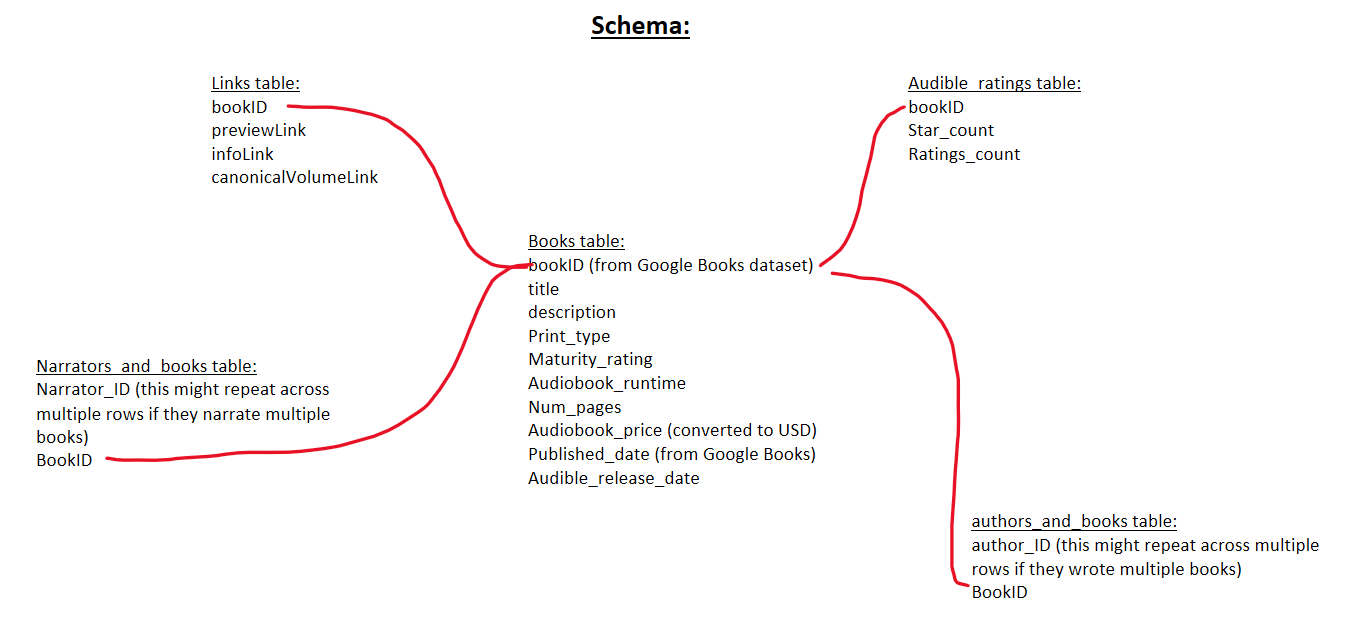

## Installs and imports

In [ ]:
# TODO: uncomment these!!
# %pip install pandas
# %pip install numpy
# %pip install psycopg2

In [ ]:
import pandas as pd
import numpy as np

import os
import time
import psycopg2


import json
from urllib.request import urlopen

# for converting strings to a format that works for URLs
from urllib.parse import quote

### Import my auth secrets

In [ ]:
# read the .env file to get my API key for Google books
# I tried to use the dotenv library but the install didn't work

with open('.env', 'r') as file:
	for line in file:
		# we want to skip empty lines or lines that are comments
		if line.strip() == '' or line.startswith('#'):
			continue
		
		# strip each like and then split it to make a key-value pair
		key, value = line.strip().split('=', 1)
		
		# set the env variable
		os.environ[key] = value

# set the API key variable so I can use it later
GOOGLE_BOOKS_API_KEY = os.getenv('API_KEY')
# set the DB password variable
DB_PASSWORD = os.getenv('DB_PASSWORD')

# Extract

## Load the Audible dataset

In [ ]:
audible_df = pd.read_csv('Data/audible_copy_pasted.csv', encoding='utf-8')
print("data from audible:")
display(audible_df.head())

In [ ]:
# sanity check that there are no character encoding issues on a couple rows that had problems before
display(audible_df[(audible_df['time'] == '9 hrs and 17 mins') & (audible_df['language'] == 'mandarin_chinese')])

## Explore the Audible dataset

In [ ]:
# what is the shape?
audible_df.shape

In [ ]:
# how many NAs are there?
audible_df.isna().sum()

In [ ]:
# Let's see if the author column always starts with 'Writtenby:'
display(audible_df[~audible_df['author'].str.contains(pat=r'^Writtenby:', regex=True)])
# wow ok, there are 0 rows that don't have that starting, that will be easy to clean

# and if the narrator column always starts with 'Narratedby:'
display(audible_df[~audible_df['narrator'].str.contains(pat=r'^Narratedby:', regex=True)])
# ok nice, once again they all follow that pattern

In [ ]:
# Now that we know these columns always start with 'Writtenby:' and 'Narratedby:', how can we split up the first and last names?
# regex: first 'Writtenby: and then either one or more of: (a capital letter followed by one or more lowercase letters), 
# basically just FirstNameOrMaybeMoreName
# or (one or more of: (a capital letter followed by a period), i.e. for an initial, followed by a capital letter and then one or more lowercase
# basically A.B.LastNameMaybeMore


# display(audible_df[~audible_df["author"].str.contains(pat=r"^Writtenby:( (([A-Z][a-z]+)+ | (([A-Z][.])+[A-Z][a-z]+))+[,]* )")])
# display(audible_df[audible_df["author"].str.contains(pat=r"^Writtenby:((([A-Z][.])+[A-Z][a-z]+)+[,]*)")])
display(audible_df[~audible_df["author"].str.contains(pat=r"^Writtenby:([A-Z][a-z]+)+")])

In [ ]:
# let's check for inconsistencies in the formatting of the 'time' column
# do they all have 'and'?
display(audible_df[~audible_df['time'].str.contains(pat=r'and', regex=True)].head())
# ok not all do

# do they all follow the <numbers><space><letters> etc. pattern?
display(audible_df[~audible_df['time'].str.contains(pat=r'^\d+\s+[A-Za-z]+')].head())

# let's get the unique values:
audible_df.loc[~audible_df['time'].str.contains(r'^\d+\s+[A-Za-z]+', regex=True), 'time'].unique()
# ok seems like it always contains 'and', except if the value is 'Less than 1 minute'

In [ ]:
# exploring the stars column
# let's see what values there are:
audible_df['stars'].unique()

In [ ]:
# How often is the stars column 'Not rated yet', or some other string that doesn't contain a digit?
display(audible_df[~audible_df['stars'].str.contains(r'\d')].shape)
# wow that's a lot of books that aren't rated yet!
display(audible_df[~audible_df['stars'].str.contains(r'\d')])

# what unique values are there?
audible_df[~audible_df['stars'].str.contains(r'\d')]['stars'].unique()
# ok seems to just be 'Not rated yet'

In [ ]:
# do the values in 'stars' all follow the same pattern?
print("check that it's always out of 5 stars:")
display(audible_df[~(audible_df['stars'].str.contains(r'out of 5 stars') 
					 | audible_df['stars'].str.contains(r'Not rated yet'))]['stars'].unique())

print("check that its always either an integer number of stars, or 1 decimal digit, or Not rated yet:")
# at the start of the string, one digit, then an optional period, then an optional digit, then it has to be a space
display(audible_df[~(audible_df['stars'].str.contains(r'^\d[.]*\d*\s') 
					 | audible_df['stars'].str.contains(r'Not rated yet'))]['stars'].unique())

print("values in 'stars' where they don't follow the 'X.X out of 5 starsXXX (1-3 digits) rating[maybe an 's']' or 'Not rated yet' pattern:")
display(audible_df[~(audible_df['stars'].str.contains(r'\d[.]*\d* out of 5 stars\d{1,3} rating[s]*') 
					 | audible_df['stars'].str.contains(r'Not rated yet'))]['stars'].unique())

print("also excluding e.g. '4.5 out of 5 stars1,869 ratings', with the comma in the ratings count:")
display(audible_df[~(audible_df['stars'].str.contains(r'\d[.]*\d* out of \d stars\d{1,3} rating[s]*') 
					 | audible_df['stars'].str.contains(r'Not rated yet')
					 | audible_df['stars'].str.contains(r'\d[.]*\d* out of \d stars\d+[,]\d+ rating[s]*')
					 )]['stars'].unique())

# ok it seems like we only have a few possible patterns in this column
# and the stars are always out of 5

In [ ]:
# Does the release date column always follow the pattern <numbers> - <numbers> - <numbers>?
display(audible_df[~audible_df['releasedate'].str.contains(r'^\d+-\d+-\d+', regex=True)])
# Ok nice they all follow that pattern

display(audible_df[~audible_df['releasedate'].str.contains(r'^\d{2}-\d{2}-\d{4}', regex=True)])
# but it appears they don't always follow DD-MM-YYYY, sometimes it is D-M-YYYY, and sometimes it is just YY

In [ ]:
# what values are there in language?
display(audible_df['language'].unique())

## Cleaning the Audible dataset

In [ ]:
# make a deep copy
cleaned_audible_df = audible_df.copy()

#### Cleaning the price column:

In [ ]:
# let's clean up the price column and get it into a float
# display(cleaned_audible_df[cleaned_audible_df['cleaned_price'].str.contains(',')])

# since there are commas in the numbers, e.g. 1,234.00, we will have to get rid of commas
cleaned_audible_df['price_no_commas'] = cleaned_audible_df['price'].str.replace(',', '')

# check if the comma removing worked correctly:
# .option_context("display.min_rows", 10000):
print('rows where price contains a comma:')
display(cleaned_audible_df[cleaned_audible_df['price'].str.contains(',')])

print("Check the NA's:")
display(cleaned_audible_df.isna().sum())
# display(cleaned_audible_df[cleaned_audible_df['price_no_commas'].isna()])

print("rows where price has a non-zero digit after the decimal place:")
display(cleaned_audible_df[cleaned_audible_df['price_no_commas'].str.contains(r'[.][1-9]', regex=True, na=False)])
# ok there are some prices that have a fraction, so we can't just make them ints

In [ ]:
# let's see what unique values are in the price column besides just digits
cleaned_audible_df[cleaned_audible_df['price'].str.contains(r'[A-Za-z]', regex=True)]['price'].unique()
# Ok nice only 'Free', let's make those 0

cleaned_audible_df['cleaned_price'] = cleaned_audible_df['price_no_commas'].apply(lambda value: 0 if value == 'Free' else value)

# let's also convert to a float
cleaned_audible_df['cleaned_price'] = cleaned_audible_df['cleaned_price'].astype(float)

display(cleaned_audible_df.head())

display(cleaned_audible_df.dtypes)

In [ ]:
# convert price from rupees to dollars
# the data was scraped from Audible on 4/7/22, and I was able to get a conversion rate of 
# 1 rupee = 0.013 USD from the next day
# and then with inflation to the latest data (January 2024), is 0.01387 USD

# also round to 2 decimal places to get only to the level of cents
cleaned_audible_df['cleaned_price_USD'] = round(cleaned_audible_df['cleaned_price'] * 0.01387, 2)

cleaned_audible_df.head()

In [ ]:
# sanity check
# with pd.option_context("display.min_rows", 10000):
display(cleaned_audible_df)

# looks good, now we can drop the other columns and rename cleaned_price
cleaned_audible_df.drop(columns=['price', 'price_no_commas', 'cleaned_price'], inplace=True)
# cleaned_audible_df.rename(columns= {'cleaned_price' : 'cleaned_price_rupees'}, inplace=True)

print("After dropping and renaming:")
display(cleaned_audible_df.head())

#### Cleaning the author and narrator columns:

In [ ]:
# In my exploration I found that every row in the author and narrator column started with
# 'Writtenby:' and 'Narratedby:', so let's remove that

# replace 'Writtenby:' with an empty string
cleaned_audible_df['author'] = cleaned_audible_df['author'].str.replace(pat=r'^Writtenby:', repl='', regex=True)

# replace 'Narrattedby:' with an empty string
cleaned_audible_df['narrator'] = cleaned_audible_df['narrator'].str.replace(pat=r'^Narratedby:', repl='', regex=True)

display(cleaned_audible_df.head())

#### Cleaning the releasedate column (converting to timestamp):

In [ ]:
# convert the release date to a datetime object
# **Important note, they seem to be in a DD-MM-YYYY (or sometimes D-M-YY, etc. but day first) format, 
# since there are some dates like 30-10-18, 25-11-14 (so the day must be first), but there is also 1-5-2018
cleaned_audible_df['cleaned_releasedate'] = pd.to_datetime(cleaned_audible_df['releasedate'], dayfirst=True, format='mixed')

# temporarily display a lot of rows to check it worked
with pd.option_context("display.min_rows", 10):
	# look at just rows where releasedate had a weird format to especially make sure it worked for those
	display(cleaned_audible_df[~cleaned_audible_df['releasedate'].str.contains(r'\d{2}-\d{2}-\d{4}', regex=True)])
	display(cleaned_audible_df)

# ok seems to have worked!

In [ ]:
# make sure there are no weird values in cleaned_releasedate
print("min release date values:")
display(cleaned_audible_df[cleaned_audible_df['cleaned_releasedate'] == cleaned_audible_df['cleaned_releasedate'].min()])
# ok the min values look reasonable

# check books that were released after today's date
print("release date values that are after today's date:")
display(cleaned_audible_df[cleaned_audible_df['cleaned_releasedate'] > pd.to_datetime('today').normalize()])
# I don't think this is a mistake since one of the original releasedate values is '9-8-2024'
# These have very weird character encoding issues and I don't think it makes sense to have books that aren't release yet
# so I'm going to drop these

cleaned_audible_df = cleaned_audible_df[cleaned_audible_df['cleaned_releasedate'] <= pd.to_datetime('today').normalize()]
print("new max release date value:")
display(cleaned_audible_df['cleaned_releasedate'].max())
# ok nice, now the max value was released about 2 weeks ago, that seems reasonable

# now let's drop the releasedate column
cleaned_audible_df.drop(columns=['releasedate'], inplace=True)

#### Cleaning the time column and extracting hours and mins:

In [ ]:
# attempt at converting the time column by splitting it into hours, mins, etc. components in different columns and then combining again
print("df with the hours extracted:")
display(cleaned_audible_df['time'].str.extract(pat=r'([A-Za-z]+\s*)+')[0].unique())

# at the start of the string, get one or more digits, then a white space, hr, maybe an s
# but only keep the digits
# i.e. we get '8 hrs' or '1 hr' and we only keep the 8 or 1
cleaned_audible_df['hours'] = cleaned_audible_df['time'].str.extract(pat=r'^(\d+)\shr[s]*')
# seems to have worked
# we have an NA if it is 0 hours, so let's fill the NAs with 0's
cleaned_audible_df['hours'] = cleaned_audible_df['hours'].fillna(0)

# with pd.option_context("display.min_rows", 10000):
display(cleaned_audible_df)

# check that it worked for when it is just '1 hr', not hrs
print("rows with time == '1 hr':")
display(cleaned_audible_df[cleaned_audible_df['time'] == '1 hr'])

# check that the fillNA worked correctly
print("rows with 0 in the hours column:")
# with pd.option_context("display.min_rows", 10000):
display(cleaned_audible_df[cleaned_audible_df['hours'] == 0])

In [ ]:
# extracting the minutes
# cleaned_audible_df['minutes'] = cleaned_audible_df['time'].str.extract(r'')
cleaned_audible_df[cleaned_audible_df['time'].str.contains(r'min$', regex=True)]
# ok it seems we have to be careful with not getting 'Less than 1 minute' and something like '1 hr and 1 min' mixed up

# one or more digits, then 1 whitespace, then 'min', then maybe an s, all this at the end of the string
# only capture the digits though
# it is important that it's at the end of the string so we don't accidentally capture the 1 from 'Less than 1 minute', 
# we only want the number when the string ends in min or mins
print("df with minutes extracted:")
cleaned_audible_df['minutes'] = cleaned_audible_df['time'].str.extract(r'(\d+)\smin[s]*$')
# cleaned_audible_df[cleaned_audible_df['time'].str.contains(r'(\d+\smin[s]*$)')]

# with pd.option_context("display.min_rows", 10000):
display(cleaned_audible_df)

# check that it correctly did NA for rows where there are no minutes
print("rows with NA in the minutes column:")
display(cleaned_audible_df[cleaned_audible_df['minutes'].isna()])

# the minutes column seems to have worked nicely, let's fill in the NAs with 0's
cleaned_audible_df['minutes'] = cleaned_audible_df['minutes'].fillna(0)

print("cleaned_audible_df with minutes NAs filled in with 0's:")
# with pd.option_context("display.min_rows", 10000):
display(cleaned_audible_df)

In [ ]:
# convert the columns to integer
cleaned_audible_df['hours'] = cleaned_audible_df['hours'].astype(int)
cleaned_audible_df['minutes'] = cleaned_audible_df['minutes'].astype(int)

cleaned_audible_df.dtypes

In [ ]:
# see how many rows are only 1 minute, to help us figure out what to do with the 'Less than 1 minute'
cleaned_audible_df[(cleaned_audible_df['hours'] == 0) & (cleaned_audible_df['minutes'] == 1)].shape

In [ ]:
# TODO: what to do with rows where it is 'Less than 1 minute'????
# let's see what unique values there are in the time column where we got NA for both hours and mins, and filled them both in with 0's:
display(cleaned_audible_df[(cleaned_audible_df['hours'] == 0) & (cleaned_audible_df['minutes'] == 0)]['time'].unique())
# Ok, just 'Less than 1 minute'. I will have to figure out how to take care of this

# how many are there?
print("# of rows where time is 'Less than 1 minute':")
display(cleaned_audible_df[cleaned_audible_df['time'] == 'Less than 1 minute'].shape[0])

# ok since it is just 61 in 88k, and since we don't have any precision smaller than minutes, 
# I think we should just round this to 1 minute
cleaned_audible_df.loc[cleaned_audible_df['time'] == 'Less than 1 minute', 'minutes'] = 1

print("rows where 'time' is 'Less than 1 minute':")
display(cleaned_audible_df[cleaned_audible_df['time'] == 'Less than 1 minute'].head())

# ok looks good, now that we have a nice hours and minutes column, we can convert that to a timedelta and drop 'time'
# cleaned_audible_df.drop(columns=['time'], inplace=True)

# convert the hours and minutes columns to separate columns that are a pandas time delta
cleaned_audible_df['hours_timedelta'] = pd.to_timedelta(cleaned_audible_df['hours'], unit='h')
cleaned_audible_df['minutes_timedelta'] = pd.to_timedelta(cleaned_audible_df['minutes'], unit='m')

# add the two timedelta columns together to get the full runtime
cleaned_audible_df['cleaned_runtime'] = cleaned_audible_df['hours_timedelta'] + cleaned_audible_df['minutes_timedelta']

print("With timedelta columns:")
display(cleaned_audible_df)

# drop the unnecessary columns, including time
cleaned_audible_df.drop(columns=['time', 'hours', 'minutes', 'hours_timedelta', 'minutes_timedelta'], inplace=True)
print("With columns dropped:")
display(cleaned_audible_df.head())

#### Cleaning the stars column:

In [ ]:
# ok we know there are only a few patterns that values in this column follow
# at the start of the string, get a number and then optionally a decimal and another number
# (we know from the exploration that it's only ever an integer for the stars, or one decimal place)
cleaned_audible_df['star_count'] = cleaned_audible_df['stars'].str.extract(r'^(\d[.]*\d*)')

cleaned_audible_df
# ok we have NAs in rows with no ratings yet but I think that actually makes sense as a value

In [ ]:
cleaned_audible_df['ratings_count'] = cleaned_audible_df['stars'].str.extract(r'([\d,]+) rating')

display(cleaned_audible_df.isna().sum())
# check that it worked
print("df after making ratings_count:")
display(cleaned_audible_df.head())

# check that it worked when there is a comma in the ratings number (e.g. 1,400 ratings)
print("rows with a comma in stars:")
display(cleaned_audible_df[cleaned_audible_df['stars'].str.contains(',')].head())


# for when there are no ratings, I think it makes sense to have ratings_count be 0, and not NA
# but star_count should be NA I think since 0 stars means something different from no reviews
cleaned_audible_df['ratings_count'] = cleaned_audible_df['ratings_count'].fillna(0)

# check that it worked when there are no ratings
print("rows where stars is 'Not rated yet':")
display(cleaned_audible_df[cleaned_audible_df['stars'].str.contains('Not rated yet')].head())

# ok looks good, now let's remove commas from the ratings_count
cleaned_audible_df['ratings_count'] = cleaned_audible_df['ratings_count'].str.replace(',', '')
# another fillna?? since I was getting weird behavior
cleaned_audible_df['ratings_count'] = cleaned_audible_df['ratings_count'].fillna(0)

print("After removing commas from ratings_count:")
display(cleaned_audible_df.head())
print("check rows with commas one last time:")
display(cleaned_audible_df[cleaned_audible_df['stars'].str.contains(',')].head())
# display(cleaned_audible_df[cleaned_audible_df['ratings_count'].str.contains('^0', regex=True, na=True)].head())

print("check NAs:")
display(cleaned_audible_df[cleaned_audible_df['ratings_count'].isna()].head())

display(cleaned_audible_df.isna().sum())

# ok looks good, now we can drop the stars column
cleaned_audible_df.drop(columns=['stars'], inplace=True)

# convert the star_count to float, and ratings_count to int
cleaned_audible_df['star_count'] = cleaned_audible_df['star_count'].astype(float)
cleaned_audible_df['ratings_count'] = cleaned_audible_df['ratings_count'].astype(int)

In [ ]:
# make a unique ID in each row of the Audible DF
# Even though I know we will need to drop some rows after this, I think this is a good time to do this

# I think name (title of the book) is a good column to use for this
# first just as a check, make sure we have only unique values in 'name'

# wow ok we do have duplicates by book name
# there are even duplicates when you group together the name, author, and narrator
# and 179 duplicates when you group together the name, author, narrator, language, and the release date
	# I think this last combination doesn't make sense for there to be duplicates
	# even if there are different runtimes of the audiobooks, I don't think it makes sense
	# to have these duplicates, and it is not a lot of rows

# duplicates = cleaned_audible_df.duplicated(subset=['name', 'author', 'narrator', 'language', 'cleaned_releasedate'])
# display(cleaned_audible_df[duplicates])

display(len(cleaned_audible_df))
display(len(cleaned_audible_df.drop_duplicates(subset=['name', 'author', 'narrator', 'language', 'cleaned_releasedate'])))
# ok looks like this will only remove the 179 rows, like expected
# let's drop them
cleaned_audible_df.drop_duplicates(subset=['name', 'author', 'narrator', 'language', 'cleaned_releasedate'], inplace=True)

# now that we have done that dropping, I feel like each row is ok to get assigned a unique ID
# since each row should be unique at this point, and I would either need to use 1 unique column
# for pd.factorize(), which we don't really have, or do something complicated to combine multiple
# columns to make a unique combination, I am just going to use each row's index
cleaned_audible_df['audible_ID'] = cleaned_audible_df.index

cleaned_audible_df.head()

### A final check of the cleaned dataframe:

In [ ]:
print("audible:")
display(cleaned_audible_df.head())

## Load data from Google Books API

In [ ]:
# version for name and author
books_found_not_perfect_match = 0
books_found_perfect_match = 0
books_not_found = 0


def google_books_query(title, author):
	# use the global version of these variables
	global books_found_not_perfect_match
	global books_found_perfect_match
	global books_not_found

	converted_title = convert_string_for_url(title)
	converted_author = convert_string_for_url(author)

	url = (
		# TODO: should I do exact phrase or not??
		#  "https://www.googleapis.com/books/v1/volumes?q=\"exact%20phrase\"intitle:"
		 "https://www.googleapis.com/books/v1/volumes?q=intitle:"
		 + converted_title
		 + "inauthor:"
		 + converted_author
		 + "&key="
		+ GOOGLE_BOOKS_API_KEY
	)

	# send a request and get a JSON response
	resp = urlopen(url)

	# parse JSON into Python as a dictionary
	book_data = json.load(resp)
	
	try:
		if "items" in book_data:
			
			volume_info = book_data["items"][0]["volumeInfo"]
			author = volume_info["authors"]
			prettify_author = author if len(author) > 1 else author[0]

			print("query title:", title)
			print("found title:", volume_info['title'])

			print("query author:", author)
			print("found author:", prettify_author)

			# perfect match
			if title == volume_info["title"]:
				 books_found_perfect_match += 1
			else:
				 books_found_not_perfect_match += 1


		else:
			print("******no results found for title:", title, "author:", author)
			books_not_found += 1

	except Exception as e:
		print("***\n\n\nError:", e)

	return book_data


def convert_string_for_url(input_string):

	# Encode the string for URL
	encoded_string = quote(input_string)

	return encoded_string

In [ ]:
# print("books_found_not_perfect_match:", books_found_not_perfect_match)
# print("books_found_perfect_match:", books_found_perfect_match)
# print("books_not_found:", books_not_found)

### Make Google Books dataframe

In [ ]:
# list_of_lists_for_df = []

In [ ]:
# TODO: clean this up!!

# TODO: make this loop over all!!
for index in range(2000, 3000):
    print("row num:", index)
    row = cleaned_audible_df.iloc[index]
# for index, row in cleaned_audible_df.iterrows():
# for index, row in cleaned_audible_df.head(10000).iterrows():
# for index, row in audible_goodreads_merged.head(100).iterrows():

    # if index is > 0 and is a multiple of 100, wait
    # this is to deal with the 100 requests per 100 seconds rate limit
    # (or at least that is what I found online)
    if index > 0 and index % 100 == 0:
        time.sleep(60)
        print("Sleeping, for the rate limit")

    print("index:", index)
    # the book title in the audible dataset is in a column called 'name'
    
    title = row["name"]
    author = row["author"]
    audible_id = row["audible_ID"]
    # ISBN = row['isbn']

    book_data = google_books_query(title, author)
    # book_data = google_books_query(ISBN)


    if book_data["totalItems"] == 0:
        # print("no results for title:", title, "with author:", author)
        print("no results!!")
    else:
        if 'items' in book_data:
            # TODO: just use the first????
            item = book_data['items'][0]
            for item in book_data["items"]:
                # TODO: change this later!!!!!!!!!!
                # if we have an exact match on the title

                if "title" in item["volumeInfo"]:
                    # if item["volumeInfo"]["title"] == title:
                        # print("exact title match")
                    """items from google books that I am deciding to keep:
                    ?? id for the google books ID for this book?

                    volumeInfo->title, authors, publishedDate, description

                    volumeInfo->industryIdentifiers (a list of dictionaries)
                    -> get the one where type is ISBN_10, and ISBN_13, and get the identifier value

                    volumeInfo->pageCount
                    volumeInfo->printType
                    volumeInfo->maturityRating

                    volumeInfo->previewLink
                    volumeInfo->infoLink
                    volumeInfo->canonicalVolumeLink
                    """

                    authors_string = np.NaN
                    if "authors" in item["volumeInfo"]:
                        authors_string = ""

                        # add all the authors to the same column, separated by a |, and take care of it later
                        for author in item["volumeInfo"]["authors"]:
                            authors_string += author + "|"

                    # default values of NA
                    ISBN_10 = np.NaN
                    ISBN_13 = np.NaN

                    # don't even attempt this loop if this section is not there
                    if "industryIdentifier" in item["volumeInfo"]:
                        # loop through the list of dictionaries, get the ISBNs
                        for ID in item["volumeInfo"]["industryIdentifier"]:
                            if ID["type"] == "ISBN_10":
                                ISBN_10 = ID["identifier"]

                            if ID["type"] == "ISBN_13":
                                ISBN_13 = ID["identifier"]

                    # had to add this since some books don't have a description
                    description_string = np.NaN
                    if "description" in item["volumeInfo"]:
                        description_string = item["volumeInfo"]["description"]

                    # title
                    title = np.NaN
                    if "title" in item["volumeInfo"]:
                        title = item["volumeInfo"]["title"]

                    # published date
                    publishedDate = np.NaN
                    if "publishedDate" in item["volumeInfo"]:
                        publishedDate = item["volumeInfo"]["publishedDate"]

                    # page count
                    pagecount = np.NaN
                    if "pageCount" in item["volumeInfo"]:
                        pagecount = item["volumeInfo"]["pageCount"]

                    # the order: id, title, authors ****have to still split it up
                    # published date, description, ISBN 10, ISBN 13, page count, print type
                    # maturity rating,
                    # preview link, info link, canonical volume link

                    list_for_this_book = [
                        # the audible ID is here so we can connect the two dataframes later
                        audible_id,
                        title,
                        item["id"],
                        item["volumeInfo"]["title"],
                        authors_string,
                        publishedDate,
                        description_string,
                        ISBN_10,
                        ISBN_13,
                        pagecount,
                        item["volumeInfo"]["printType"],
                        item["volumeInfo"]["maturityRating"],
                        item["volumeInfo"]["previewLink"],
                        item["volumeInfo"]["infoLink"],
                        item["volumeInfo"]["canonicalVolumeLink"],
                    ]

                    print(list_for_this_book)

                    list_of_lists_for_df.append(list_for_this_book)
                    # break since we already found one perfect match in the google books data set,
                    # for this entry in the audible data set
                    break

                else:
                    print("no title found! item:", item)

In [ ]:
print("books_found_not_perfect_match:", books_found_not_perfect_match)
print("books_found_perfect_match:", books_found_perfect_match)
print("books_not_found:", books_not_found)

In [ ]:
len(list_of_lists_for_df)

In [ ]:
google_books_df = pd.DataFrame(
    list_of_lists_for_df,
    columns=[
		"audible_ID",
        "audible_title",
        "Google_books_ID",
        "title",
        "authors_string",
        "publishedDate",
        "description_string",
        "ISBN_10",
        "ISBN_13",
        "pagecount",
        "printType",
        "maturityRating",
        "previewLink",
        "infoLink",
        "canonicalVolumeLink",
    ]
)


## Explore and clean the Google books df

In [ ]:
cleaned_google_books_df = google_books_df.copy()

In [ ]:
display(cleaned_google_books_df.shape)

display(cleaned_google_books_df.head())

display(cleaned_google_books_df.isna().sum())

### Drop ISBN columns

In [ ]:
# it seems something went wrong with getting the ISBNs, all the values are NA
# I am going to drop these columns
cleaned_google_books_df = cleaned_google_books_df.drop(columns=['ISBN_10', 'ISBN_13'])

### Drop NAs in the authors_string column

In [ ]:
# Not sure if I should drop these rows with no author data
# I think I'm going to drop them since it's a small fraction of the data, and 
# an author is an important part of data about a book
display(google_books_df[google_books_df['authors_string'].isna()].head())

# dropping NAs in authors_string
display(len(cleaned_google_books_df.dropna(subset=['authors_string'])))
# ok looks good let's drop them
cleaned_google_books_df = cleaned_google_books_df.dropna(subset=['authors_string'])

### Clean the publishedDate column

In [ ]:
# there are definitely NAs in this column
cleaned_google_books_df[(~pd.isnull(cleaned_google_books_df['publishedDate'])) & (~cleaned_google_books_df['publishedDate'].str.contains(r'\d{4}-\d{2}-\d{2}', na=False, regex=True))]
# wow ok lots of different values, even just a year
# I am not going to clean this up here, since in the last project I had to put things back into strings to load it into the DB

### Clean the pageCount column

In [ ]:
display(cleaned_google_books_df.isna().sum())
# ok some NAs here
display(cleaned_google_books_df['pagecount'].unique())

# there are not that many NAs, and they are anyways going to get in the way of me 
# converting this column to int

# drop the NAs
display(len(cleaned_google_books_df))
display(len(cleaned_google_books_df.dropna(subset=['pagecount'])))
# ok looks good

cleaned_google_books_df = cleaned_google_books_df.dropna(subset=['pagecount'])

# convert to int
cleaned_google_books_df['pagecount'] = cleaned_google_books_df['pagecount'].astype('int')

In [ ]:
# check datatypes after the conversion:
cleaned_google_books_df.dtypes

## Integrate the data

In [ ]:
# audible_google_integrated_df = cleaned_audible_df.merge(google_books_df, on='audible_ID', indicator=True, how='outer')
audible_google_integrated_df = cleaned_audible_df.merge(cleaned_google_books_df, on='audible_ID', how='right')
# display(len(audible_google_integrated_df[audible_google_integrated_df['_merge'] == 'both']))
display(len(audible_google_integrated_df))
display(audible_google_integrated_df)

# Transform

## Normalize the data

### Make tables for links, ratings, and books

In [ ]:
# make dataframes for the other tables in the RDB
links_df = google_books_df[
    ["Google_books_ID", "previewLink", "infoLink", "canonicalVolumeLink"]
]

audible_ratings_df = audible_google_integrated_df[
    ["Google_books_ID", "star_count", "ratings_count"]
]


books_df = audible_google_integrated_df[
    [
        "Google_books_ID",
        "title",
        "description_string",
        "printType",
        "maturityRating",
        "cleaned_runtime",
        "pagecount",
        "cleaned_price_USD",
        "publishedDate",
        "cleaned_releasedate",
    ]
]

# rename columns just to clean it up
books_df = books_df.rename(
    columns={
        "description_string": "description",
        "printType": "print_type",
        "maturityRating": "maturity_rating",
        "cleaned_runtime": "audiobook_runtime",
        "pagecount": "num_pages",
        "cleaned_price_USD": "audiobook_price_USD",
        "publishedDate": "book_published_date",
        "cleaned_releasedate": "audible_release_date",
    }
)

display(links_df)
display(audible_ratings_df)
display(books_df)

### Make tables for authors and narrators

In [ ]:
# make a table of Google_books_ID's and author names

book_IDs_and_authors = []
book_IDs_and_narrators = []


# # split up the authors_string column on the | that I added, and strip off whitespace
for index, row in audible_google_integrated_df.head(1000).iterrows():
	# deal with the authors
	if not pd.isnull(row['authors_string']):
		# print("authors_string:", row['authors_string'])
		authors_for_this_book = row['authors_string'].split('|')
		# print(authors_for_this_book)

		book_ID = row['Google_books_ID']

		# loop through authors on this book, but ignore if it's an empty string from the splitting
		for author in authors_for_this_book:
			if author.strip() != '':
				# add the pair to the list that will get turned into a df
				book_IDs_and_authors.append([book_ID, author.strip()])


	# deal with the narrators
	if not pd.isnull(row['narrator']):
		# print("narrator:", row['narrator'])
		narrators_for_this_book = row['narrator'].split(',')
		# print(narrators_for_this_book)

		book_ID = row['Google_books_ID']

		# loop through narrators on this book, but ignore if it's an empty string from the splitting
		for narrator in narrators_for_this_book:
			if narrator.strip() != '':
				# add the pair to the list that will get turned into a df
				book_IDs_and_narrators.append([book_ID, narrator.strip()])
	

# display(book_IDs_and_authors)
book_IDs_and_authors_df = pd.DataFrame(book_IDs_and_authors, columns=['Google_books_ID', 'author_name'])

print("duplicated rows in book_IDs_and_authors_df:")
display(book_IDs_and_authors_df[book_IDs_and_authors_df.duplicated()])
# we have 5 duplicate combinations of book ID and author name, which I don't really understand, but I'm going to drop it
book_IDs_and_authors_df = book_IDs_and_authors_df.drop_duplicates()

print("book_IDs_and_authors_df without duplicates:")
display(book_IDs_and_authors_df)


# narrators:
book_IDs_and_narrators_df = pd.DataFrame(book_IDs_and_narrators, columns=['Google_books_ID', 'narrator_name'])

print("duplicated rows in book_IDs_and_narrators_df:")
display(book_IDs_and_narrators_df[book_IDs_and_narrators_df.duplicated()])

# I also don't understand the duplicates here, but I am going to drop them
book_IDs_and_narrators_df = book_IDs_and_narrators_df.drop_duplicates()

print("book_IDs_and_narrators_df without duplicates:")
display(book_IDs_and_narrators_df)

### Final cleanup and drop columns that are now in separate tables

In [ ]:
# can now drop some columns now that we've normalized and stuff



# rename columns!

# Load

## Set up the database

In [ ]:
# Helper functions
import psycopg2
def get_conn_cur():

 conn = psycopg2.connect(
    host="final-project-db.cx6cm26umviq.us-east-1.rds.amazonaws.com",
    database="final_project_db",
    user="oseymour",
    password=DB_PASSWORD,
    port='5432'
    )

 cur = conn.cursor()
 return(conn, cur)

## Helper functions

In [ ]:
# run_query function
def run_query(query_string):

    conn, cur = get_conn_cur()  # get connection and cursor

    cur.execute(query_string)  # executing string as before

    my_data = cur.fetchall()  # fetch query data as before

    # here we're extracting the 0th element for each item in cur.description
    colnames = [desc[0] for desc in cur.description]

    cur.close()  # close
    conn.close()  # close

    return (colnames, my_data)  # return column names AND data


# Column name function for checking out what's in a table
def get_column_names(table_name):  # argument of table_name
    conn, cur = get_conn_cur()  # get connection and cursor

    # Now select column names while inserting the table name into the WERE
    column_name_query = (
        """SELECT column_name FROM information_schema.columns
    WHERE table_name = '%s' """
        % table_name
    )

    cur.execute(column_name_query)  # execute
    my_data = cur.fetchall()  # store

    cur.close()  # close
    conn.close()  # close

    return my_data  # return


# Check table_names
def get_table_names():
    conn, cur = get_conn_cur()  # get connection and cursor

    # query to get table names
    table_name_query = """SELECT table_name FROM information_schema.tables
       WHERE table_schema = 'public' """

    cur.execute(table_name_query)  # execute
    my_data = cur.fetchall()  # fetch results

    cur.close()  # close cursor
    conn.close()  # close connection

    return my_data  # return your fetched results


# make sql_head function
def sql_head(table_name):
    conn, cur = get_conn_cur()  # get connection and cursor

    # Now select column names while inserting the table name into the WERE
    head_query = """SELECT * FROM %s LIMIT 5; """ % table_name

    cur.execute(head_query)  # execute
    colnames = [desc[0] for desc in cur.description]  # get column names
    my_data = cur.fetchall()  # store first five rows

    cur.close()  # close
    conn.close()  # close

    df = pd.DataFrame(data=my_data, columns=colnames)  # make into df

    return df  # return


# drop a table from your rdb (if you try to create a table that already exists, it'll throw an error)
def my_drop_table(tab_name):
    conn, cur = get_conn_cur()
    tq = """DROP TABLE IF EXISTS %s CASCADE;""" % tab_name
    cur.execute(tq)
    conn.commit()

## Load in the data

In [ ]:
list_of_tables_loaded = []

# drop the tables if they exist
# for table in list_of_tables_loaded:
# 	my_drop_table(table)

# make tables
conn, cur = get_conn_cur()
# scouting
# create_query = """CREATE TABLE scouting (ColonyEmiID varchar(100), behavior_timestamp timestamp, Who varchar(30),
# Location varchar(30), Nest varchar(30), X1stToEnter int, ArenaArea varchar(30));"""

# cur.execute(create_query)
# conn.commit()


# # tandem
# create_query = """CREATE TABLE tandem (ColonyEmiID varchar(100), behavior_timestamp timestamp, Who varchar(30),
# Role varchar(30), Destination varchar(30));"""

# cur.execute(create_query)
# conn.commit()


# # videos
# create_query = """CREATE TABLE videos (VideoColonyEmiID varchar(50), ColonyEmiID varchar(100), 
# FileName varchar(50), FileNameNoExt varchar(50), RecordingStartTime timestamp, Length interval);"""

# cur.execute(create_query)
# conn.commit()

# # transport
# create_query = """CREATE TABLE transport (ColonyEmiID varchar(100), behavior_timestamp timestamp, 
# Who varchar(30), WhatsBeingCarried varchar(30), WhoIsCarried varchar(30), NestCarriedFrom varchar(30),
# NestCarriedTo varchar(30));"""

# cur.execute(create_query)
# conn.commit()


# # colonies_and_emigrations
# create_query = """CREATE TABLE colonies_and_emigrations (ColonyEmiID varchar(100),
# Colony varchar(30), EmiNum int, EmiNotes varchar(50));"""

# cur.execute(create_query)
# conn.commit()

# cur.close()
# conn.close()

# Queries

In [ ]:
# TODO: have to do queries!!!